In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../')


from astroLuSt.physics import photometry as alphph
from astroLuSt.synthetics import images as alsyim

importlib.reload(alphph)
importlib.reload(alsyim)


<module 'astroLuSt.synthetics.images' from '/home/lukas/github/astroLuSt/demos/physics/../../astroLuSt/synthetics/images.py'>

# Magnitudes and Fluxes

In [2]:
m,      dm     = 10,  .1
m_ref,  dm_ref = 5 ,  .01
f_ref,  df_ref = 2 ,  .1
d,      dd     = 20,  5 #pc
plx,    dplx   = 1/d, 1/dd #arcsec

## Converting Magnitudes and Fluxes

In [3]:
f, df = alphph.mags2fluxes(m=m, m_ref=m_ref, f_ref=f_ref, dm=dm, dm_ref=dm_ref, df_ref=df_ref)
print(f'Flux from mags: {f:.3f} +/- {df:.3f}')
m, dm_ = alphph.fluxes2mags(f=f, f_ref=f_ref, m_ref=m_ref, df=df, df_ref=df_ref, dm_ref=dm_ref)
print(f'Mag from fluxes: {m:.3f} +/- {dm_:.3f} mag')

Flux from mags: 0.020 +/- 0.003
Mag from fluxes: 10.000 +/- 0.229 mag


## Distance Modulus

In [4]:
importlib.reload(alphph)

DM = alphph.DistanceModule(
    m=m, M=None, d=d, plx=None,
    dm=dm, dM=None, dd=dd, dplx=None,
)

print(DM)



DistanceModule(
    m=10.0, M=8.494850021680094,
    d=20, plx=0.05,
    dm=0.1, dM=0.6428681023790647,
    dd=5, dplx=0.0125,
)


## Converting to Wesenheit Magnitude

In [5]:
W, dW = alphph.wesenheit_magnitude(M=DM.M, CI=0.3, R=0)
print(f'Wesenheit Magnitude: ({W:.3f} +/- {dW:.3f}) mag')

Wesenheit Magnitude: (8.495 +/- 0.000) mag


## Adding Magnitudes and Estimating Target Star Contribution

Generate some stars

TPF(
    size=(100, 100),
    mode='mag',
    f_ref=1, m_ref=0,
    store_stars=True,
    rng='Generator',
    verbose=0,
)
Estimated Aperture: 10
[ 50.          50.         630.95734448  -7.          10.        ]


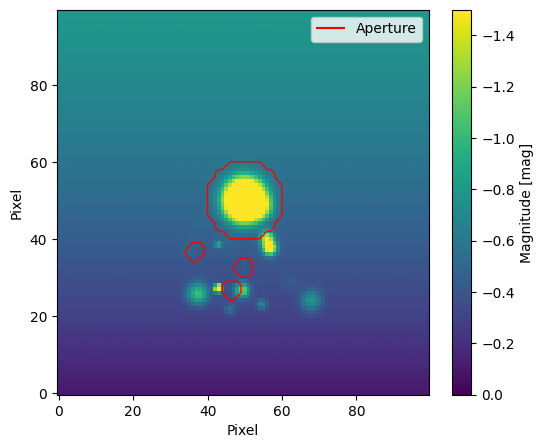

In [7]:
importlib.reload(alsyim)

TPF = alsyim.TPF(
    size=100,
    # mode='flux',
    mode='mag',
    f_ref=1, m_ref=0,
    store_stars=True,
    rng=None,
    verbose=0
)
print(TPF)

#random stars (distribution specified via list)
TPF.add_stars(
    nstars=30,
    posx={'dist':'chisquare', 'params':[50]},
    posy={'dist':'chisquare', 'params':[30]},
    # f={'dist':'uniform', 'params':[1,10]},
    m={'dist':'uniform', 'params':[-4,4]},
    aperture={'dist':'poisson', 'params':[5]},
)
#specified stars
TPF.add_stars(
    nstars=1,
    posx=np.array([50]),
    posy=np.array([50]),
    # f=np.array([500]),
    m=np.array([-7]),
    aperture=np.array([10]),
)

#custom (linear) trend
TPF.add_custom('lineary', amplitude=1)

#noise
TPF.add_noise(amplitude=5E-2, bias=1E-1)


#plot (including multiple apertures)
# fig, axs = TPF.plot_result(plot_apertures=range(-4,0,1))
fig, axs = TPF.plot_result(plot_apertures=range(-4,0,1), pcolormesh_kwargs=dict(vmin=-1.5, vmax=0))

try:
    print(f'Estimated Aperture: {TPF.aperture_from_mask(TPF.stars[-1,:,:,2]):.0f}')
except:
    pass
print(TPF.starparams[-1])

### Calculating total magnitude of all contaminants
* Weighted by distance to target star

In [8]:
importlib.reload(alphph)

#get target and contaminants
targ = TPF.starparams[-1]
cont = TPF.starparams[:-1]

#calculate distances
cont_pos = cont[:,:2]
dists = np.sqrt(np.sum((cont_pos - targ[:2])**2, axis=1))

#generate weights via distances
w = dists/dists.max()   #normalize distances to a max of

#calculate total magnitude of contaminants
cont_m = np.array([c[2] for c in cont])
cont_dm = np.random.uniform(0.1, 1, cont_m.shape[0])    #some random errors
m_tot, dm_tot = alphph.mags_sum(m=cont_m, w=w, dm=cont_dm, axis=None)
print(f'Total magnitude of contaminants: {m_tot:.5f} +/- {dm_tot:.5f} mag')


Total magnitude of contaminants: -2.49168 +/- 0.55662 mag


### Calculate fractional contribution of target star

In [9]:
importlib.reload(alphph)

print(targ[3], print(cont_m.shape))
m_cont_pre, dm_cont_pre = alphph.mags_contribution(m=targ[3], m_cont=m_tot,  dm=None, dm_cont=dm_tot)       #using calculated total magnitude
m_cont_fly, dm_cont_fly = alphph.mags_contribution(m=targ[3], m_cont=cont_m, dm=None, dm_cont=cont_dm, w=w) #calculate total magnitude on the fly

print(f'Contribution of Target (precalculated): {m_cont_pre:.3f} +/- {dm_cont_pre:.3f}')
print(f'Contribution of Target (on the fly):    {m_cont_fly:.3f} +/- {dm_cont_fly:.3f}')


(30,)
-7.000000000000001 None
Contribution of Target (precalculated): 0.985 +/- 0.008
Contribution of Target (on the fly):    0.985 +/- 0.008


For multiple targets at once

In [10]:
m_cont, dm_cont = alphph.mags_contribution(m=[targ[3],cont_m[0]], m_cont=cont_m[1:], dm=[0,cont_dm[0]], dm_cont=cont_dm[1:])
print(f'Contribution of Targets (precalculated): {m_cont} +/- {dm_cont}')

Contribution of Targets (precalculated): [0.97857009 0.06189415] +/- [0.01052568 0.07908843]


Will return 1 if no contaminants

In [11]:
importlib.reload(alphph)
m_nocont, dm_nocont = alphph.mags_contribution(m=targ[3], m_cont=[], dm=4, dm_cont=None)

print(f'Contribution of Target (no contaminant): {m_nocont:.3f} +/- {dm_nocont:.3f}')

Contribution of Target (no contaminant): 1.000 +/- 0.000


In [12]:
importlib.reload(alphph)

f_targ, df_targ = alphph.mags2fluxes(m=targ[3], m_ref=0, f_ref=1, dm=0, dm_ref=0, df_ref=0)
f_cont, df_cont = alphph.mags2fluxes(m=cont_m,  m_ref=0,  f_ref=1, dm=cont_dm, dm_ref=0, df_ref=0)
f_cont, df_cont = alphph.flux_contribution(f=f_targ, f_cont=f_cont, df=df_targ, df_cont=df_cont)
# f_cont, df_cont = alphph.flux_contribution(f=f_targ, f_cont=[])

print(f'Contribution of Target (on the fly):    {f_cont:.3f} +/- {df_cont:.3f}')


Contribution of Target (on the fly):    0.977 +/- 0.012


### Polars Compatible Versions
Alows for fast calculation in huge datasets

In [13]:
import polars as pl
importlib.reload(alphph)

#generate synthetic dataset for testing
ntargs  = 3     #number of unique targets
nconts  = 20    #number of unique contaminants
nrows   = 100   #number of total rows in table
targets = np.array([
    np.arange(ntargs),              #unique id
    (np.random.rand(ntargs)-0.8)*5  #magnitude
]).T
targets = np.append(targets, alphph.mags2fluxes(targets[:,1])[0].reshape(-1,1), axis=1)

contaminants = np.array([
    np.arange(nconts),              #unique id
    (np.random.rand(nconts)-0.2)*5  #magnitude
]).T
contaminants = np.append(contaminants, alphph.mags2fluxes(contaminants[:,1])[0].reshape(-1,1), axis=1)

data = np.concatenate([
    targets[     np.random.choice(targets.shape[0],       nrows,  replace=True)],
    contaminants[np.random.choice(contaminants.shape[0],  nrows,  replace=True)],
], axis=1)



df = pl.DataFrame(
    data=data,
    schema=[
        'targ_id',
        'targ_mag',
        'targ_flux',
        'cont_id',
        'cont_mag',
        'cont_flux',
    ],
).filter((pl.col('targ_id')!=pl.col('cont_id')))    #remove target itself from contaminants

display(df.head())


df_cont_mag = alphph.mags_contribution_polars(
    df,
    id_col_targ='targ_id',
    app_mag_col_targ='targ_mag',
    app_mag_col_cont='cont_mag',
).with_columns([
    pl.col('contribution').alias('contribution_mags'),
    pl.col('n_contaminants').alias('n_contaminants_mags'),
])
df_cont_flux = alphph.flux_contribution_polars(
    df,
    id_col_targ='targ_id',
    flux_col_targ='targ_flux',
    flux_col_cont='cont_flux',
).with_columns([
    pl.col('contribution').alias('contribution_flux'),
    pl.col('n_contaminants').alias('n_contaminants_flux'),
])

df_cont = df_cont_mag.join(df_cont_flux, on='targ_id')
df_cont = df_cont.select(sorted(df_cont.columns))

display(df_cont)

targ_id,targ_mag,targ_flux,cont_id,cont_mag,cont_flux
f64,f64,f64,f64,f64,f64
1.0,-0.05711,1.054009,15.0,2.629906,0.088723
1.0,-0.05711,1.054009,0.0,-0.593507,1.72744
1.0,-0.05711,1.054009,16.0,0.533282,0.611909
2.0,0.779155,0.487908,16.0,0.533282,0.611909
1.0,-0.05711,1.054009,12.0,0.794831,0.480914


cont_flux,cont_mag,contribution,contribution_flux,contribution_mags,contribution_right,n_contaminants,n_contaminants_flux,n_contaminants_mags,n_contaminants_right,targ_flux,targ_id,targ_mag
f64,f64,f64,f64,f64,f64,u32,u32,u32,u32,f64,f64,f64
15.578147,-2.98129,0.025853,0.025853,0.025853,0.025853,36,36,36,36,0.413432,0.0,0.95899
23.908709,-3.44639,0.042223,0.042223,0.042223,0.042223,34,34,34,34,1.054009,1.0,-0.05711
13.101244,-2.793281,0.035904,0.035904,0.035904,0.035904,25,25,25,25,0.487908,2.0,0.779155


### Pixel-Wise Total Flux

Generate a movie of stars (TPF series)

/home/lukas/github/astroLuSt/demos/physics/../../astroLuSt/physics/photometry.py:385: RuntimeWarning: divide by zero encountered in log10
  m = -2.5*np.log10(f/f_ref) + m_ref
/home/lukas/github/astroLuSt/demos/physics/../../astroLuSt/physics/photometry.py:388: RuntimeWarning: divide by zero encountered in divide
  dm =  df     *np.abs(-2.5*1/(np.log(10)*f)) \
/home/lukas/github/astroLuSt/demos/physics/../../astroLuSt/physics/photometry.py:388: RuntimeWarning: invalid value encountered in multiply
  dm =  df     *np.abs(-2.5*1/(np.log(10)*f)) \
/home/lukas/github/astroLuSt/demos/physics/../../astroLuSt/physics/photometry.py:388: RuntimeWarning: overflow encountered in divide
  dm =  df     *np.abs(-2.5*1/(np.log(10)*f)) \
MovieWriter ffmpeg unavailable; using Pillow instead.


TPF_Series(
    size=(15, 15),
    mode='mag',
    f_ref=1, m_ref=0,
    rng='Generator',
    verbose=0,
)



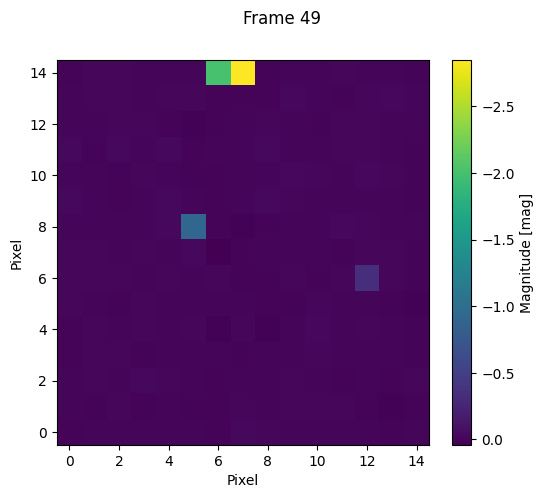

In [52]:
importlib.reload(alsyim)

#define variability of magnitudes over time
def mf_var(tp, fm):
    period = 100
    amp    = 7
    rperiods = np.random.uniform(40, 50, size=fm[:-1].shape)
    ramps    = np.random.uniform(.1, 2,  size=rperiods.shape)
    
    fm[-1]  = fm[-1] * amp*(np.sin(2*np.pi*tp/period)+3) + 2E-3*np.random.randn()
    fm[:-1] = fm[:-1] * ramps*(np.sin(2*np.pi*tp/rperiods)+2) + 1E-3*np.random.randn(*fm[:-1].shape)

    return fm

times = np.linspace(0,100,50)

TPFS = alsyim.TPF_Series(
    size=15,
    # mode='flux',
    mode='mag',
    f_ref=1, m_ref=0,
    rng=None,
    verbose=0    
)
print(TPFS)

frames, starparams_s = TPFS.rvs(
    times=times,
    variability=mf_var,
    add_stars_kwargs=dict(
        nstars=5,
        m={'dist':'uniform', 'params':[-1,2]},
    ),
    add_noise_kwargs=dict(amplitude=1, bias=1),
    # add_custom_kwargs=dict(trend='linearx', amplitude=1.5),
)

fig, axs, anim = TPFS.plot_result(
    save='../_gfx/test.gif',
    # pcolormesh_kwargs=dict(vmin=0, vmax=3),
)


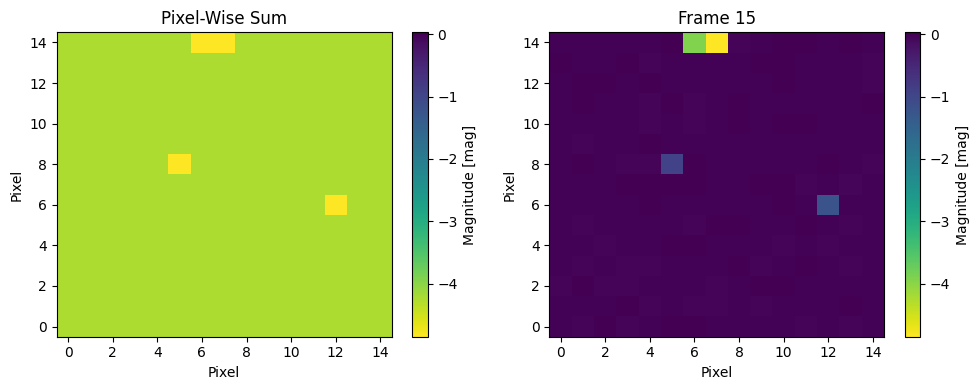

In [53]:

comparison_idx = 15

frame_sum = frames[0].copy()
frame_sum[:,:,2], _ = alphph.mags_sum(m=frames[:,:,:,2], w=None, axis=0)

vmin = frames[comparison_idx,:,:,2].min()
vmax = frames[comparison_idx,:,:,2].max()

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title(f'Pixel-Wise Sum')
ax2.set_title(f'Frame {comparison_idx}')
mesh1 = ax1.pcolormesh(frame_sum[:,:,0], frame_sum[:,:,1], frame_sum[:,:,2], vmin=vmin, vmax=vmax, cmap='viridis_r')
mesh2 = ax2.pcolormesh(frames[comparison_idx,:,:,0], frames[comparison_idx,:,:,1], frames[comparison_idx,:,:,2], vmin=vmin, vmax=vmax, cmap='viridis_r')

cbar1 = fig.colorbar(mesh1, ax=ax1)
cbar2 = fig.colorbar(mesh2, ax=ax2)

ax1.set_xlabel('Pixel')
ax2.set_xlabel('Pixel')
ax1.set_ylabel('Pixel')
ax2.set_ylabel('Pixel')
cbar1.set_label('Magnitude [mag]')
cbar2.set_label('Magnitude [mag]')
fig.tight_layout()
plt.show()